# Isotonic Regression

First, let's explain the concept of isotonic regression. Isotonic regression is a powerful technique of modelling the relationship between two variables while imposing a specific monotonicity constraint known as isotonicity. This constraint ensures that the relationship between the variables will be either non-decreasing or non-increasing. In simpler terms, isotonic regression seeks to find a piecewise constant function that is either non-decreasing or non-increasing, providing the best fits to the given data points while adhering to the monotonicity constraint. The following plot shows an example of isotonic regression (solid red line) compared to linear regression (dashed green line) on the same data (this image is from https://en.wikipedia.org/wiki/Isotonic_regression).

![isotonic](images/isotonic_regression.png)


Now, let's see how isotonic regression can help us to create an improved reliability diagram:

[Dimitriadis, T., Gneiting, T., & Jordan, A. I. (2021). Stable reliability diagrams for probabilistic classifiers. Proceedings of the National Academy of Sciences, 118(8).](https://www.pnas.org/doi/10.1073/pnas.2016191118)

Reliability diagrams are commonly used as a tool to investigate the calibration across probabilistic thresholds. Dimitriadis et al. (2021) showed that the traditional approach of binning-and-counting, where the forecast probabilities are binned, and the conditional non-exceedance probability of respective outcomes is plotted versus the midpoint of the bin,  used for creating reliability diagrams is sensitive to the choice of bins. They proposed that the use of Consistent, Optimal, Reproducible, and Pool-adjacent-violators (PAV) algorithm (CORP) based reliability diagrams addresses the binning issue. CORP approach uses nonparametric isotonic regression and PAV algorithm to generate non-decreasing empirical reliability curves that are optimal in mathematically well-defined ways.

Now let's see how we can use `isoreg` module in `scores` to calculate PAV-calibrated probability and then use them to create the CORP reliability diagram.

In [24]:
from scores.processing.isoreg_impl import isotonic_fit
import numpy as np
import plotly.graph_objects as go

For this tutorial, we generate synthetic forecast and observation data. To keep it simple, assume that these data are single-value mean forecasts of temperature and their corresponding observations over 100 locations for a single time (valid time).

In [25]:
# Generate some synthetic forecast and observation data
np.random.seed(42)
num_stations = 100
min_temperature = 0.0
max_temperature = 20.0
forecast_data = min_temperature + np.random.rand(num_stations) * (max_temperature - min_temperature)
observation_data = min_temperature + np.random.rand(num_stations) * (max_temperature - min_temperature)

Note that here we used Numpy arrays of forecast and observation, however, `isotonic_fit` accepts both `numpy.ndarray` array and `xarray.DataArray`. Now, lets calculate the isotonic regression:

In [26]:
iso_fit_result = isotonic_fit(
    fcst=forecast_data, obs=observation_data, functional="mean", bootstraps=100, confidence_level=0.95
)

The following is a simple code to create reliability diagram using the output of isotonic regression (`isotonic_fit`):

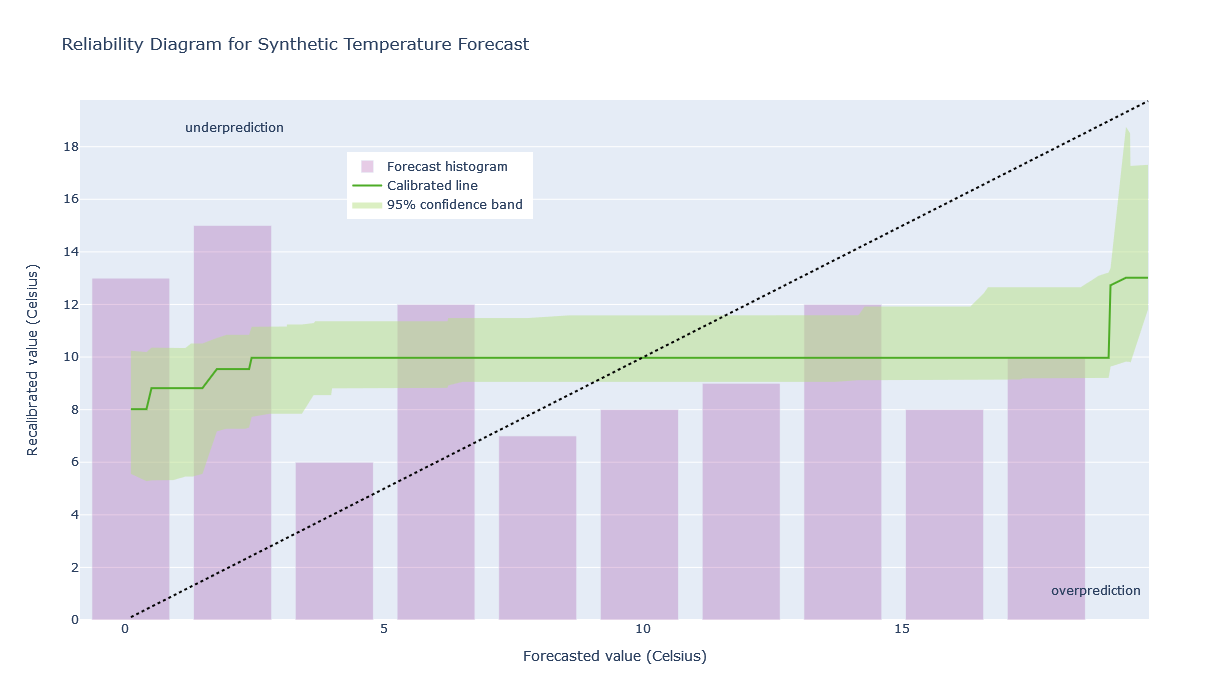

In [27]:
figure = go.Figure()
band_fillcolour = "rgba(184,225,134,0.5)"
line_colour = "#4dac26"
hist_color = "rgba(128,0,128,0.2)"

total_min = min(np.min(iso_fit_result["fcst_sorted"]), np.min(iso_fit_result["confidence_band_lower_values"]))
total_max = max(np.max(iso_fit_result["fcst_sorted"]), np.max(iso_fit_result["confidence_band_upper_values"]))

# Generate 10 bins for forecast histogram
bins = np.linspace(np.min(iso_fit_result["fcst_sorted"]), np.max(iso_fit_result["fcst_sorted"]), 11)
hist, _ = np.histogram(
    iso_fit_result["fcst_sorted"],
    bins=bins,
    weights=iso_fit_result["fcst_counts"],
)

figure.add_trace(
    go.Scatter(
        x=iso_fit_result["fcst_sorted"],
        y=iso_fit_result["confidence_band_upper_values"],
        mode="lines",
        line=dict(width=0, color=band_fillcolour),
        showlegend=False,
        name="95% confidence band",
    )
)
figure.add_trace(
    go.Scatter(
        x=iso_fit_result["fcst_sorted"],
        y=iso_fit_result["confidence_band_lower_values"],
        mode="lines",
        line=dict(width=0, color=band_fillcolour),
        fillcolor=band_fillcolour,
        fill="tonexty",
        name="95% confidence band",
    )
)
figure.add_shape(
    type="line", x0=total_min, y0=total_min, x1=total_max, y1=total_max, line=dict(color="black", dash="dot")
)
figure.add_trace(
    go.Scatter(
        x=iso_fit_result["fcst_sorted"],
        y=iso_fit_result["regression_values"],
        name="Calibrated line",
        mode="lines",
        line=dict(color=line_colour),
    )
)
figure.add_bar(
    x=bins,
    y=hist,
    width=1.5,
    marker=dict(
        color=hist_color,
    ),
    name="Forecast histogram",
)

figure.add_annotation(x=total_min + 2, y=total_max - 1, text="underprediction", showarrow=False)

figure.add_annotation(x=total_max - 1, y=total_min + 1, text="overprediction", showarrow=False)

figure.update_layout(
    title="Reliability Diagram for Synthetic Temperature Forecast",
    xaxis_title="Forecasted value (Celsius)",
    yaxis_title="Recalibrated value (Celsius)",
    legend=dict(x=0.25, y=0.9),
    height=700,
    width=700,
)
figure.show()

Here, we explain how to interpret the reliability diagram.

The reliability diagram shows what would be an optimally re-calibrated forecast value for each forecasted value. As it was mentioned, the re-calibrated curve is derived using isotonic regression that minimises the error score across the set of forecasts based on assumption of isotonicity (i.e., the re-calibrated forecast values cannot decrease as forecasted values increase). In this diagram, x-axis demonstrates the forecast values (here, our synthetic temperature forecasts), and y-axis shows the re-calibrated (regression) values. In reliability diagram, the diagonal line (here displayed by a black dashed line) shows an ideal (well-calibrated) forecast. If a point is above the ideal line, it indicates under-prediction, whereas point below the ideal line indicates over-prediction. Here we also displayed the 95% confidence bands estimated by 100 bootstrapping samples. The confidence bands indicate uncertainty of the re-calibrated values due to sampling uncertainty, and they are particularly important in the case of comparing multiple forecast systems. Moreover, producing the forecast counts `fcst_counts` as an item in the return dictionary of the `isotonic_fit` function allows to create the forecast histogram. Displaying both reliability diagram and forecast histogram in one plot is a common practice in weather forecasting that provides a better insight into the calibration of the forecasts.

Please note that in this example, we use isotonic regression for a **single-value mean forecast**, but it can also be used for **probabilistic forecasts**. In the case of single-value mean forecast, as can be seen in this example, users can set `functional='mean'`, and for quantile forecast, the `functional` can be set to `'mean'`. For a probabilistic forecast of a binary event (e.g., probability of at least 5 mm precipitation falling over a 24 hour period), where the forecasts take values on the range [0, 1] and binary observations take values from the set {0,1}, user can specify the `functional` argument as `'mean'` to calculate the isotonic regression. The `functional` argument determines that what is the functional that the forecast is targeting. Therefore, it can be used to find an optimal regression fit in each block, subject to a non-decreasing monotonicity constraint, using the pool adjacent violators (PAV) algorithm.